In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
train_data = pd.read_csv("etch_train.csv")
grouped = train_data.groupby("Run ID")
train_data_split = {key: group for key, group in grouped}
for key, sub_df in train_data_split.items():
    print(f"DataFrame for {key}:")
    print(sub_df)
    print("\n")

DataFrame for 2901:
     Run ID     Time  Step Number  BCl3 Flow  Cl2 Flow  RF Btm Pwr  \
0      2901   10.379            4        752       752         131   
1      2901   11.946            4        751       753         132   
2      2901   13.028            4        751       753         134   
3      2901   14.049            4        751       755         134   
4      2901   15.133            4        751       753         133   
..      ...      ...          ...        ...       ...         ...   
107    2901  123.150            5        752       754         132   
108    2901  124.170            5        752       754         132   
109    2901  125.210            5        752       754         133   
110    2901  126.230            5        752       753         135   
111    2901  127.260            5        751       753         134   

     RF Btm Rfl Pwr  Endpt A  He Press  Pressure  ...  RF Phase Err  RF Pwr  \
0                 0      643       101      1230  ...       

In [177]:
data_trained = np.ndarray((len(train_data_split.keys()), 39))
feature_count = 19
for i, (key, value) in enumerate(train_data_split.items()):
    ar1 = np.empty((0, feature_count))
    ar2 = np.empty((0, feature_count))
    data_trained[i, 0] = key
    for ii in range(value.shape[0]):
        if value.iloc[ii, 2] == 4:
            ar1 = np.concatenate((ar1, np.array(value.iloc[ii, 3:]).reshape(1, -1)))
        else:
            ar2 = np.concatenate((ar2, np.array(value.iloc[ii, 3:]).reshape(1, -1)))
    ar1_mean = np.mean(ar1, axis=0)
    ar2_mean = np.mean(ar2, axis=0)
    data_trained[i, 1:] = np.append(ar1_mean, ar2_mean)
print(data_trained.shape)

(75, 39)


## 测试集

In [201]:
test_data = pd.read_csv("etch_test.csv")
grouped = test_data.groupby("Run ID")
test_data_split = {key: group for key, group in grouped}
for key, sub_df in test_data_split.items():
    print(f"DataFrame for {key}:")
    print(sub_df)
    print("\n")

DataFrame for 2915:
    Run ID      Time  Step Number  BCl3 Flow  Cl2 Flow  RF Btm Pwr  \
0     2915    9.7188            4      750.0     753.0       133.0   
1     2915    9.7500            4      751.0     752.0       133.0   
2     2915   10.7420            4      751.0     754.0       134.0   
3     2915   11.7620            4      751.0     752.0       132.0   
4     2915   12.7810            4      751.0     752.0       135.0   
..     ...       ...          ...        ...       ...         ...   
95    2915  105.7000            5      752.0     755.0       134.0   
96    2915  106.7200            5      752.0     753.0       132.0   
97    2915  107.7400            5      751.0     754.0       134.0   
98    2915  108.7600            5      752.0     755.0       135.0   
99    2915  109.7800            5      752.0     753.0       133.0   

    RF Btm Rfl Pwr  Endpt A  He Press  Pressure  ...  RF Phase Err  RF Pwr  \
0                0      897     100.0    1261.0  ...         

In [202]:
data_tested = np.ndarray((len(test_data_split.keys()), 39))
feature_count = 19
for i, (key, value) in enumerate(test_data_split.items()):
    ar1 = np.empty((0, feature_count))
    ar2 = np.empty((0, feature_count))
    data_tested[i, 0] = key
    for ii in range(value.shape[0]):
        if value.iloc[ii, 2] == 4:
            ar1 = np.concatenate((ar1, np.array(value.iloc[ii, 3:]).reshape(1, -1)))
        else:
            ar2 = np.concatenate((ar2, np.array(value.iloc[ii, 3:]).reshape(1, -1)))
    ar1_mean = np.mean(ar1, axis=0)
    ar2_mean = np.mean(ar2, axis=0)
    data_tested[i, 1:] = np.append(ar1_mean, ar2_mean)
print(data_tested.shape)

(52, 39)


## PCA降维,K-means

In [232]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


scaler = StandardScaler()
data_trained_scaled = scaler.fit_transform(data_trained[:, 1:])

pca = PCA(n_components=2)
data_trained_pca = pca.fit_transform(data_trained_scaled)

print("贡献率:", pca.explained_variance_ratio_)

kmeans = KMeans(n_clusters=1, random_state=42)
kmeans.fit(data_trained_scaled)
labels = kmeans.labels_

scaler1 = StandardScaler()
data_tested_scaled = scaler.fit_transform(data_tested[:, 1:])

pca1 = PCA(n_components=2)
data_tested_pca = pca1.fit_transform(data_tested_scaled)

print("贡献率1:", pca1.explained_variance_ratio_)

kmeans1 = KMeans(n_clusters=2, random_state=42)
kmeans1.fit(data_tested_scaled)
labels1 = kmeans1.labels_

贡献率: [0.29602849 0.15724951]
贡献率1: [0.25344932 0.12569435]


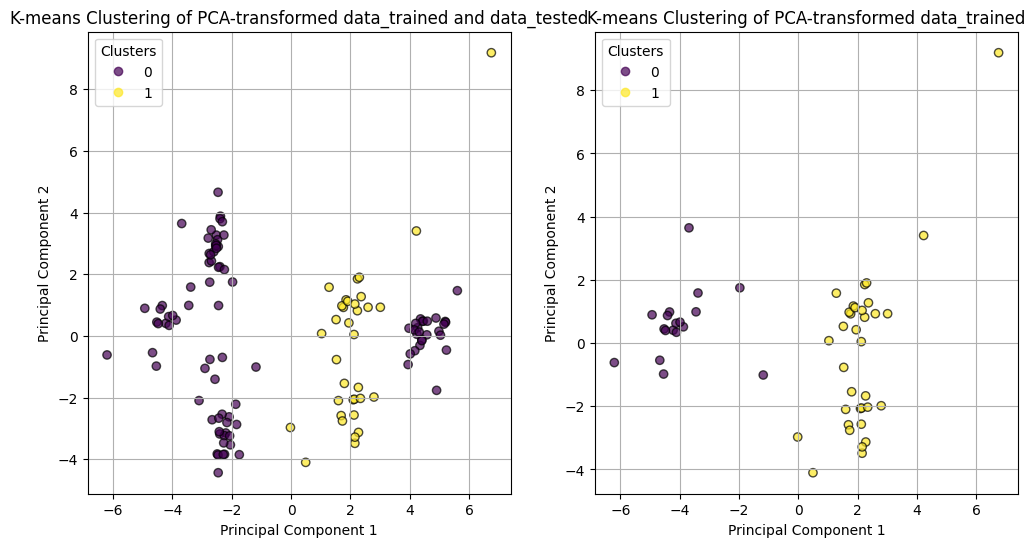

In [234]:
# 画图
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
scatter = plt.scatter(
    data_trained_pca[:, 0],
    data_trained_pca[:, 1],
    c=labels,
    cmap="viridis",
    edgecolor="k",
    alpha=0.7,
)
scatter = plt.scatter(
    data_tested_pca[:, 0],
    data_tested_pca[:, 1],
    c=labels1,
    cmap="viridis",
    edgecolor="k",
    alpha=0.7,
)
plt.title("K-means Clustering of PCA-transformed data_trained and data_tested")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True)
plt.subplot(1, 2, 2)
scatter = plt.scatter(
    data_tested_pca[:, 0],
    data_tested_pca[:, 1],
    c=labels1,
    cmap="viridis",
    edgecolor="k",
    alpha=0.7,
)
plt.title("K-means Clustering of PCA-transformed data_trained")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True)
plt.show()

In [258]:
data_tested,labels1
result=np.concatenate((data_tested[:,0].reshape(-1,1),labels1.reshape(-1,1)),axis=1)
result_csv=pd.DataFrame(result,columns=['Run ID','Label'])
result_csv.to_csv('cyq_lzh_xcf_刻蚀机异常检测.csv',index=False)

: 